## Data loading

In [1]:
# Load data and packages
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
import datetime as datetime
from collections import Counter
import time
import seaborn as sns
from scipy import stats
import plotly.figure_factory as ff
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import classification_report
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

directory_path = os.getcwd() + "\\Data\\sorting_event_volumes_2023.csv"

df = pd.read_csv(directory_path)

## Data cleaning

In [2]:
def fill_missing_events(df):
    df_filled_list = []
    
    for center in df['sorting_center_name'].unique():
        df_center = df[df['sorting_center_name'] == center]
        output_belts = df_center['output_belt'].unique()
        
        min_date = df_center['scanning_date'].min()
        max_date = df_center['scanning_date'].max()

        all_dates = pd.date_range(start=pd.Timestamp(year=min_date.year, month=1, day=1), end=pd.Timestamp(year=max_date.year, month=max_date.month, day=1) + pd.offsets.MonthEnd(0))
        
        all_combinations = pd.MultiIndex.from_product(
            [[center], all_dates, output_belts],
            names=['sorting_center_name', 'scanning_date', 'output_belt']
        )
        
        all_combinations_df = pd.DataFrame(index=all_combinations).reset_index()
        df_filled_center = pd.merge(all_combinations_df, df_center, 
                                    on=['sorting_center_name', 'scanning_date', 'output_belt'], 
                                    how='left')
        
        df_filled_center['no_of_events'] = df_filled_center['no_of_events'].fillna(0.0001)
        df_filled_list.append(df_filled_center)
    
    df_filled = pd.concat(df_filled_list, ignore_index=True)
    
    return df_filled

In [3]:
# Data cleaning
print("Number of rows original dataset is: " + str(df.shape[0]))

df = df.loc[df["event_type"] == "LAJ", :]
df.drop(['event_location', 'input_belt', 'position'], axis=1, inplace = True)
df.dropna(inplace = True)
df['output_belt'] = df['output_belt'].astype(int)
df = df.groupby(['sorting_center_name', 'scanning_date', 'output_belt'], as_index = False)['no_of_events'].sum()
df['scanning_date'] = pd.to_datetime(df['scanning_date'])
df = fill_missing_events(df)

print("Number of rows cleaned dataset is: " + str(df.shape[0]))

Number of rows original dataset is: 8949721
Number of rows cleaned dataset is: 243090


## Data preparation

In [4]:
# Data preparation
df['day'] = df['scanning_date'].dt.day
df['month'] = df['scanning_date'].dt.month
df['weekday'] = df['scanning_date'].dt.dayofweek + 1
df['week'] = df['scanning_date'].dt.isocalendar().week
df['week_of_month'] = (df['day'] - 1) // 7 + 1
df['yearday'] = df['scanning_date'].dt.day_of_year
#df['yearday_sin'] = np.sin(df['yearday'] / 7 * 2 * np.pi)
#df['yearday_cos'] = np.cos(df['yearday'] / 7 * 2 * np.pi)

sorting_center_names = df["sorting_center_name"].unique()
df["sorting_center_name"].value_counts()

sorting_center_name
TAMPERE      55115
VANTAA       54750
LIETO        41610
KUOPIO       40150
OULU         39785
SEINÄJOKI    11680
Name: count, dtype: int64

## Descriptive statistics

In [5]:
# Descriptive statistics (Jelmer)

# For analysis exclude the null events
filtered_df = df[df['no_of_events'] >= 1]

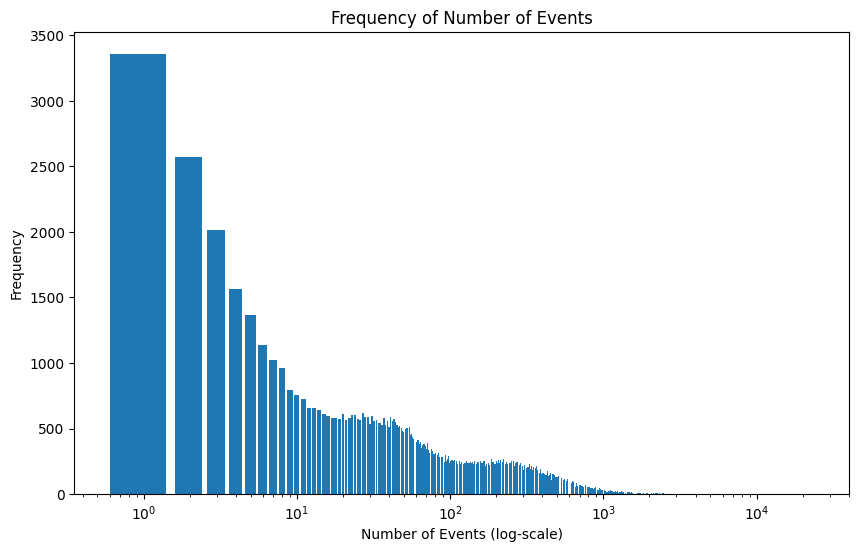

In [6]:
event_counts = filtered_df['no_of_events'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
plt.bar(event_counts.index, event_counts.values)
plt.xscale('log')
plt.xlabel('Number of Events (log-scale)')
plt.ylabel('Frequency')
plt.title('Frequency of Number of Events')
plt.show()

In [7]:
fig = px.strip(filtered_df, 
                x='no_of_events', 
                y='sorting_center_name', 
                color='sorting_center_name',
                title='Spread of Number of Events by Sorting Center',
                labels={'no_of_events': 'Number of Events', 'sorting_center_name': 'Sorting Center'},
                stripmode='overlay')

fig.show()

All dates contain data, except for five. Namely; April 9 (Easter Sunday), June 24 (Midsummer Holiday), December 24 (Christmas Eve), December 25 (Christmas), December 31 (New Years').

## Data visualizations

### Aggregate demand planning horizon

We will focus on the sorting center VANTAA when creating data visualizations

In [25]:
# Sorting center is VANTAA
df_VANTAA = df[df["sorting_center_name"] == "VANTAA"]

In [51]:
# Aggregate demand planning horizon (Mats)
import pandas as pd
import matplotlib.pyplot as plt

def total_orders_per_period(df, period):
    totals = df.groupby(period)['no_of_events'].sum()

    timeframe = ""

    if period == "day":
        timeframe = "month"
        
        valid_months = {day: 12 for day in range(1, 29)}
        valid_months[29] = 11
        valid_months[30] = 11
        valid_months[31] = 7

        year = df.iloc[0]["scanning_date"].year
        if (year % 4 == 0 and (year % 100 != 0 or year % 400 == 0)):
            valid_months[29] = 12

        for index in range(len(totals)):
            totals[index+1] = totals[index+1] / valid_months[index+1]
    elif period == "weekday":
        timeframe = "week"
    elif period == "week":
        timeframe = "year"

    plt.figure(figsize=(40, 12))
    plt.plot(totals.index, totals.values, marker='o')
    plt.xlabel('{}'.format(period))
    plt.ylabel('Number of events ({})'.format(period))
    plt.ylim(0, 1.2 * totals.max())
    plt.title('Number of events in a {} over the {}'.format(period, timeframe))
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()

### Demand over the year

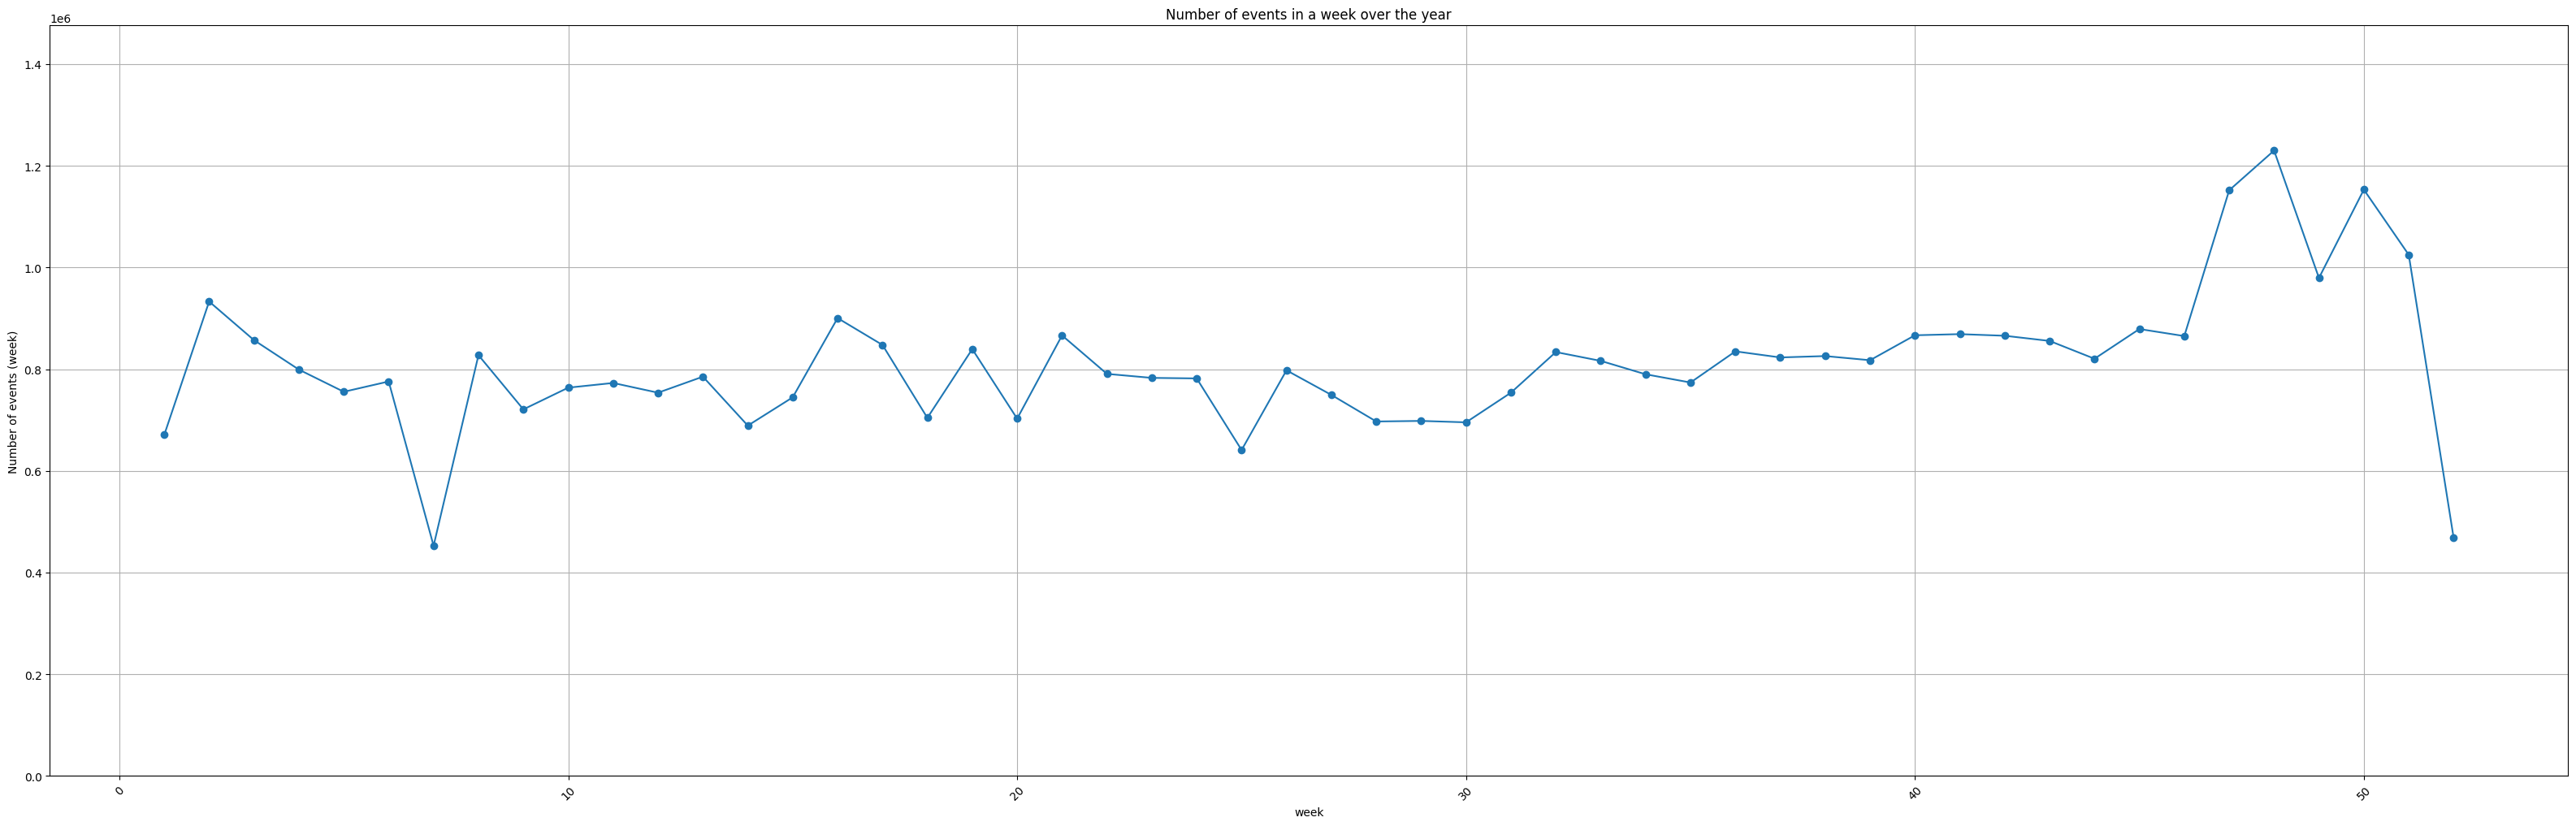

In [52]:
total_orders_per_period(df_VANTAA, "week")

### Boxplots

Don't look at the boxplot at the moment, they don't make sense yet

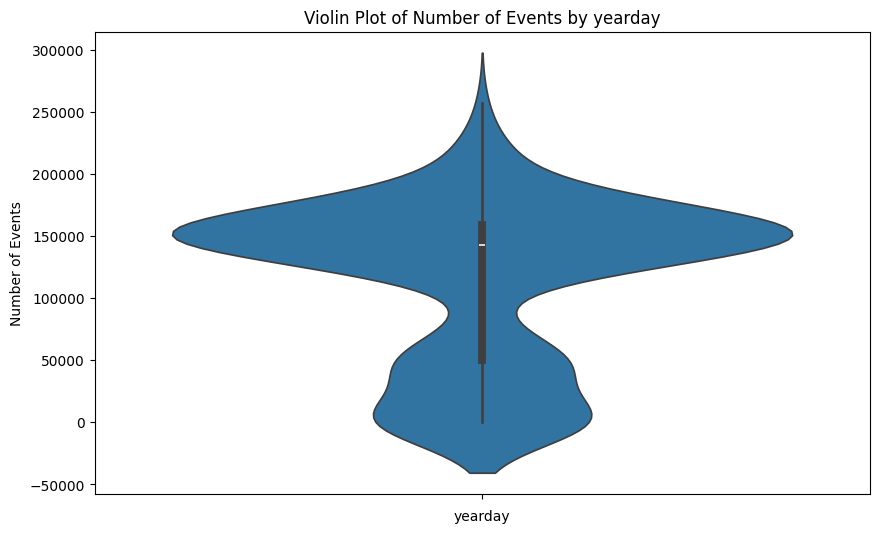

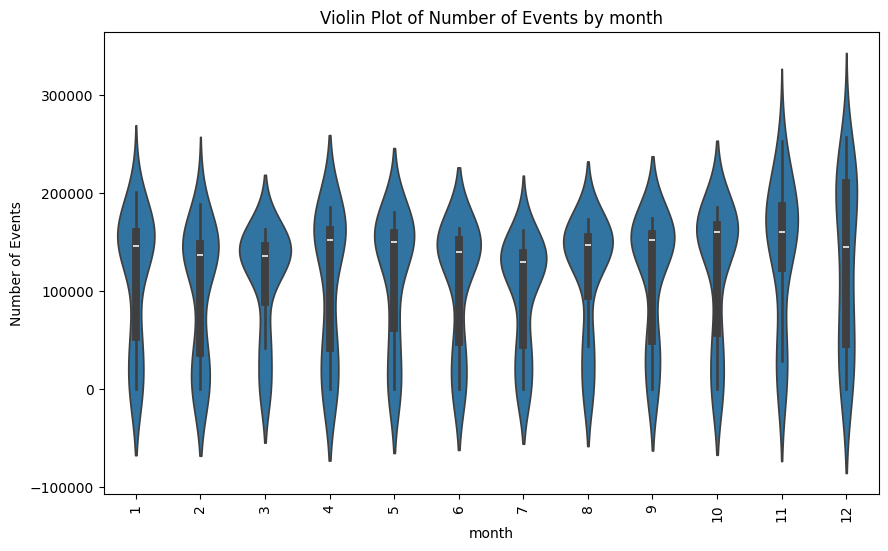

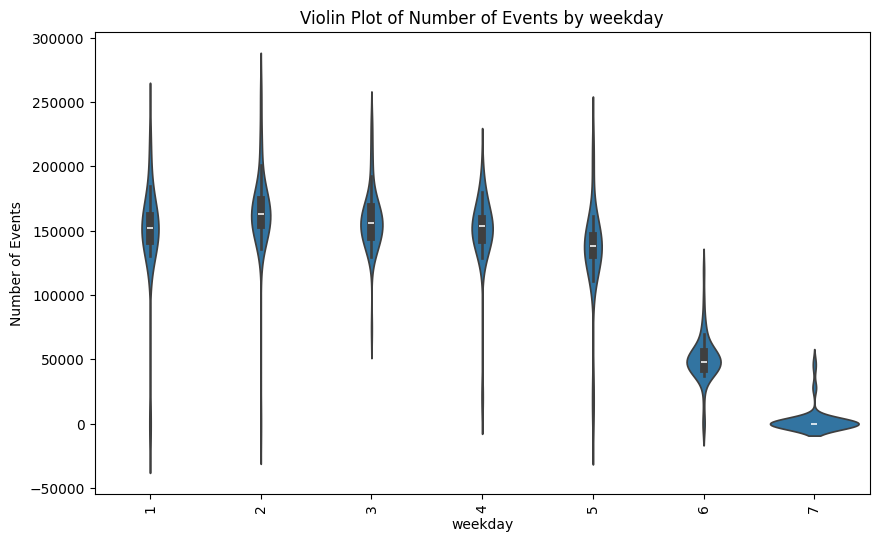

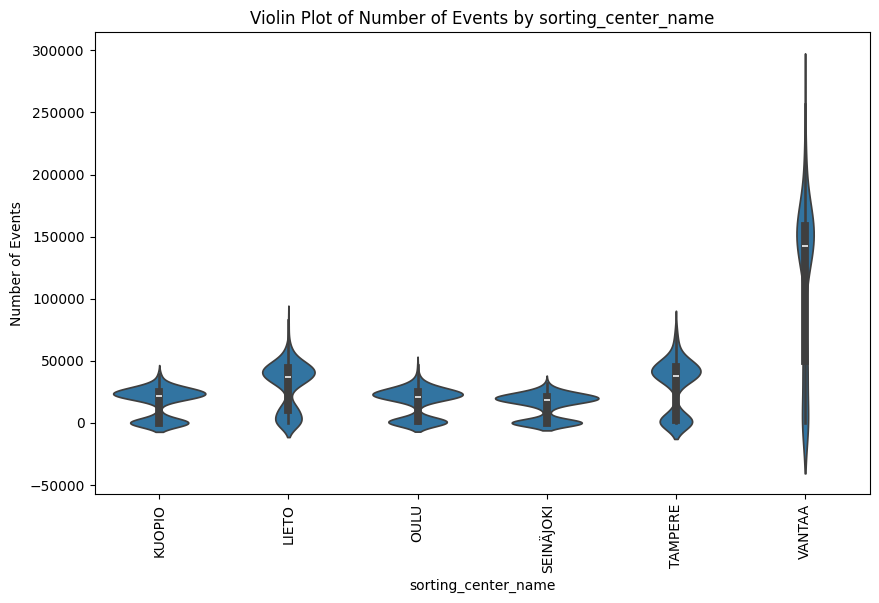

In [46]:
def plot_violin(df, period = "yearday"):
    if period == "yearday":
        df_period = df.groupby(["yearday"])["no_of_events"].sum().reset_index()
    else:
        df_period = df.groupby(["yearday", period])["no_of_events"].sum().reset_index()

    plt.figure(figsize=(10, 6))
    if period == "yearday":
        sns.violinplot(y="no_of_events", data=df_period)
    else:
        sns.violinplot(x = period, y="no_of_events", data=df_period)

    plt.xlabel("{}".format(period))
    plt.ylabel("Number of Events")
    plt.title("Violin Plot of Number of Events by {}".format(period))

    plt.xticks(rotation=90)
    plt.show()

# Yearly
plot_violin(df_VANTAA)

# Monthly
plot_violin(df_VANTAA, "month")

# Weekday
plot_violin(df_VANTAA, "weekday")

# Yearly per sorting center
plot_violin(df, "sorting_center_name")

### Day of the month

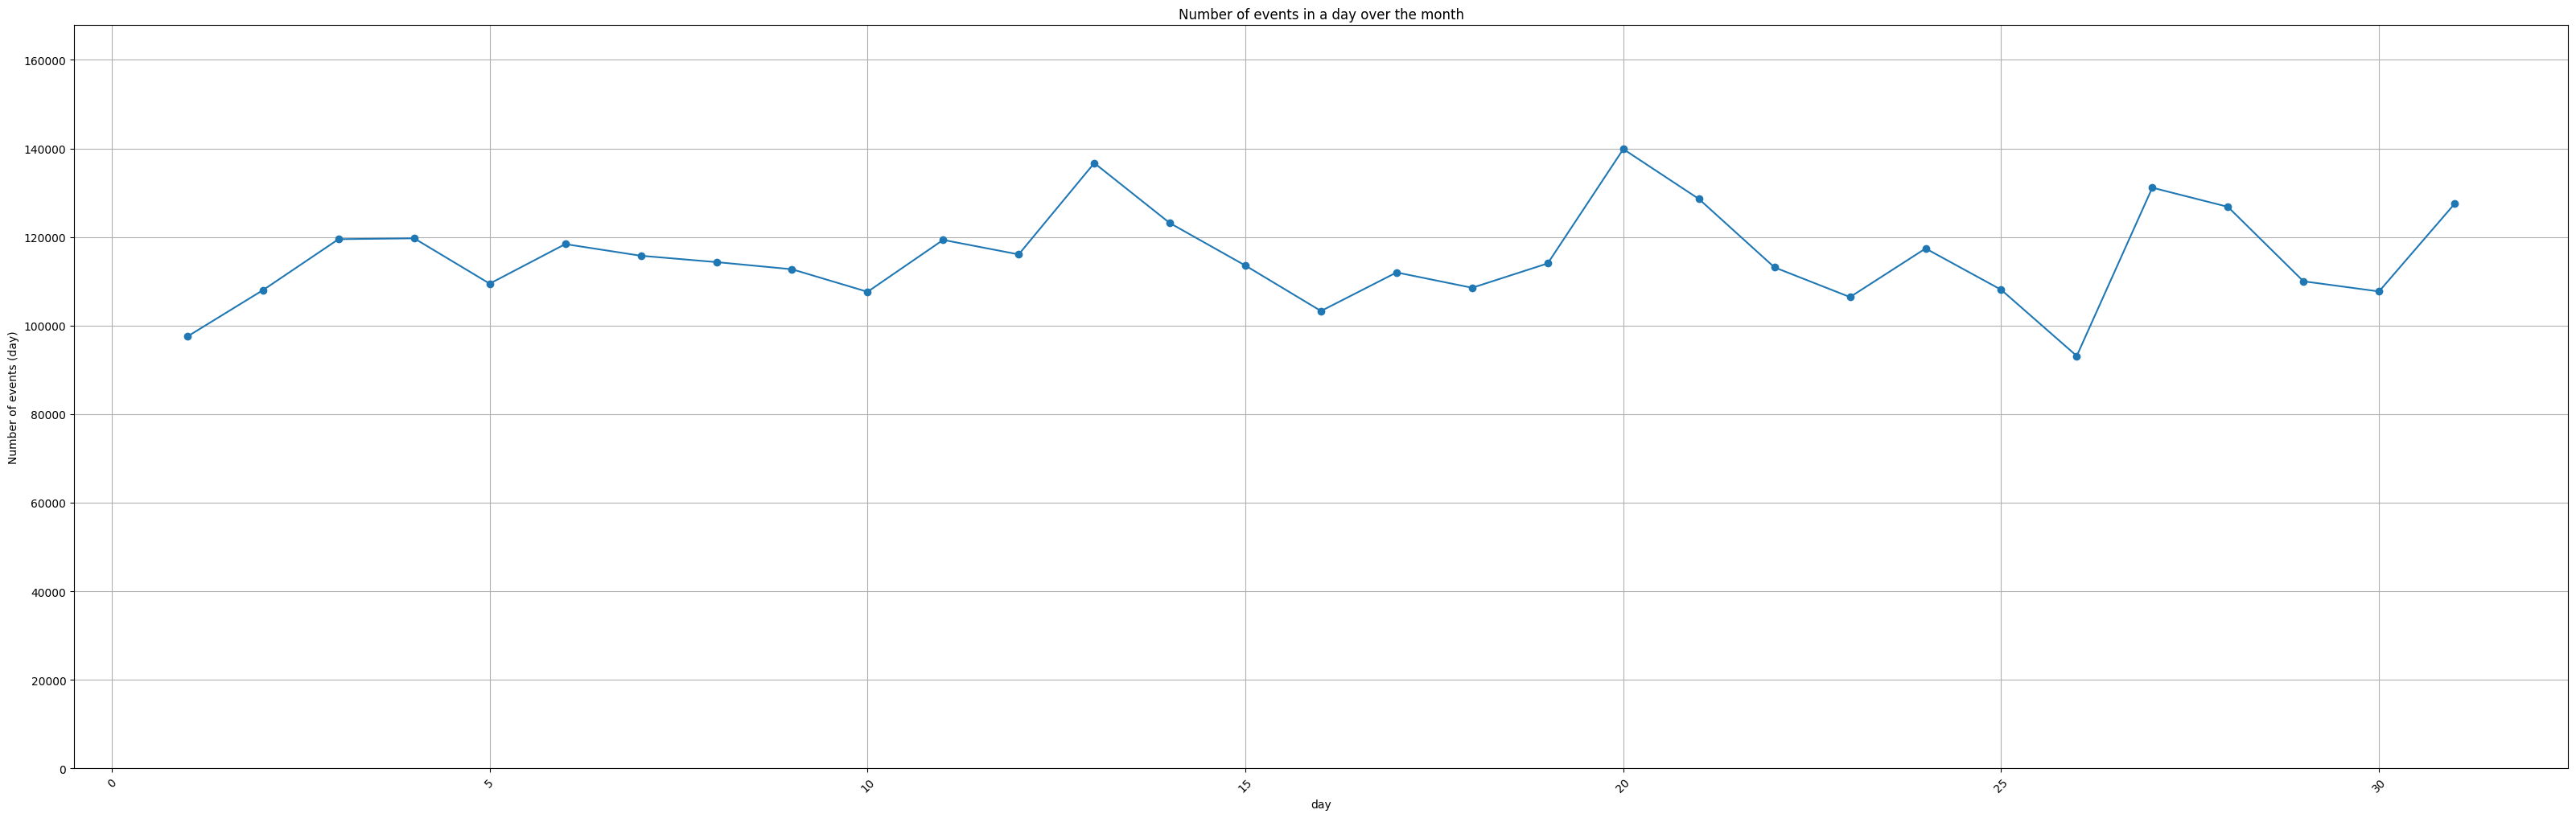

In [53]:
total_orders_per_period(df_VANTAA, "day")

## Linear Regression Model
Before trying to estimate a linear regression, it might be interesting to study the correlations of the variables with the number of events.

In [ ]:

#determine correlations
target_covariance_matrix = adf.corr()[['no_of_events']]
print(target_covariance_matrix)
sns.heatmap(target_covariance_matrix,annot=True, cmap='coolwarm')

This colormap shows that the orders correlate with the day of the week. It was also attempted to put the day of the year in a trigonometric function with a period of 7 days, for which higher correlation was found with the cosine function. The reason is that the beginning of the week is more busy than the end, and the cosine function has its peak at 0.

For the linear regression model, lag data has to be created. Lags are the datapoints of x steps back in time. The best result was found by using 2 lags when estimating the model only on aggregate data of the large Vantaa sorting center.

In [ ]:
vantaa = adf[adf['sorting_center_name']=='VANTAA']
vantaa
# Create lag features (e.g., lag 1, lag 2)
def create_lag_features(series, lags):
    lagged_data = pd.DataFrame()
    for lag in range(1, lags+1):
        lagged_data[f'lag_{lag}'] = series.shift(lag)
    return lagged_data

# Create features and target
lags = 2  # You can change the number of lags
X = create_lag_features(vantaa['no_of_events'], lags)
X.dropna(inplace=True)
y = vantaa['no_of_events'][lags:]  # Target variable is the actual series shifted by the number of lags
dates = vantaa['scanning_date'][lags:]  # Corresponding dates for the target

# Split the data into train and test sets
X_train, X_test, y_train, y_test, dates_train, dates_test = train_test_split(
    X, y, dates, test_size=0.2, shuffle=False
)

# Create and train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"Test RMSE: {rmse}")

In [ ]:
# Plot the actual vs predicted values
plt.figure(figsize=(10, 6))

# Plot actual values
plt.plot(dates_test, y_test, label='Actual Values', color='blue', marker='o')

# Plot predicted values
plt.plot(dates_test, y_pred, label='Predicted Values', color='red', linestyle='--', marker='x')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual vs Predicted Values Over Time')
plt.xticks(rotation=45)
plt.legend()

# Show plot
plt.tight_layout()
plt.show()

## (Artificial) Neural Network

## ARIMA

## LSTM